In [1]:
import opendatasets as od
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder

### Download the dataset

In [2]:
od.download('https://www.kaggle.com/jsphyg/weather-dataset-rattle-package')
raw_df = pd.read_csv('weather-dataset-rattle-package/weatherAUS.csv')
raw_df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: lilongz
Your Kaggle Key: ········


100%|██████████████████████████████████████████████████████████████████████| 3.83M/3.83M [00:01<00:00, 3.40MB/s]


### Create training, validation and test sets

In [3]:
year = pd.to_datetime(raw_df.Date).dt.year
train_df, val_df, test_df = raw_df[year < 2015], raw_df[year == 2015], raw_df[year > 2015]

### Create inputs and targets

In [4]:
input_cols = list(train_df.columns)[1:-1]
target_col = 'RainTomorrow'
train_inputs, train_targets = train_df[input_cols].copy(), train_df[target_col].copy()
val_inputs, val_targets = val_df[input_cols].copy(), val_df[target_col].copy()
test_inputs, test_targets = test_df[input_cols].copy(), test_df[target_col].copy()

### Identify numeric and categorical columns

In [5]:
numeric_cols = train_inputs.select_dtypes(include=np.number).columns.tolist()[:-1]
categorical_cols = train_inputs.select_dtypes('object').columns.tolist()

### Imputer missing numerical values

In [6]:
imputer = SimpleImputer(strategy = 'mean').fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = imputer.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = imputer.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = imputer.transform(test_inputs[numeric_cols])

### Scale numeric features

In [8]:
scaler = MinMaxScaler().fit(raw_df[numeric_cols])
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

### One-hot encode categorical features

In [10]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore').fit(raw_df[categorical_cols])
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

# Model Training and Evaluation


In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib

### Select the columns to be used for training/prediction

In [12]:
X_train = train_inputs[numeric_cols + encoded_cols]
X_val = val_inputs[numeric_cols + encoded_cols]
X_test = test_inputs[numeric_cols + encoded_cols]

### Create and train the model

In [13]:
model = LogisticRegression(solver='liblinear')
model.fit(X_train, train_targets)

LogisticRegression(solver='liblinear')

### Generate predictions and probabilities

In [14]:
train_preds = model.predict(X_train)
train_probs = model.predict_proba(X_train)
accuracy_score(train_targets, train_preds)

0.8519002326815528

### Helper function to predict, compute accuracy & plot confustion matrix

In [33]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [38]:
def predict_and_plot(inputs, targets, name=''):
    preds = model.predict(inputs)
    accuracy = accuracy_score(targets, preds)
    print("Accuracy: {:.2f}%".format(accuracy * 100))
    
    cf = confusion_matrix(targets, preds, normalize='true')
    plt.figure(dpi = 100)
    sns.heatmap(cf, annot=True)
    plt.xlabel('Prediction')
    plt.ylabel('Target')
    plt.title('{} Confusion Matrix'.format(name))
    plt.show()
    
    return preds

### Evaluate on validation and test set

Accuracy: 85.41%


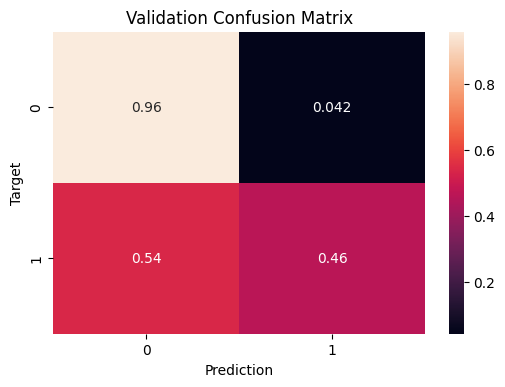

Accuracy: 84.25%


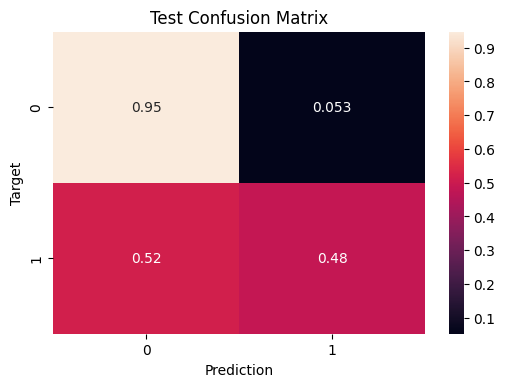

In [39]:
val_preds = predict_and_plot(X_val, val_targets, 'Validation')
test_preds = predict_and_plot(X_test, test_targets, 'Test')

In [32]:
# # Save the trained model & load it back
# aussie_rain = {'model': model, 'imputer': imputer, 'scaler': scaler, 'encoder': encoder,
#                'input_cols': input_cols, 'target_col': target_col, 'numeric_cols': numeric_cols,
#                'categorical_cols': categorical_cols, 'encoded_cols': encoded_cols}
# joblib.dump(aussie_rain, 'aussie_rain.joblib')
# aussie_rain2 = joblib.load('aussie_rain.joblib')